In [1]:
from QuantumSystem import QuantumSystemConfig, QuantumSystem

import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_qubits = 6
init_ones = [2, 3, 4]
init_state = ''.join(['1' if i in init_ones else '0' for i in range(num_qubits)])[::-1]
J = 0.2
h = 1.2
alpha = np.pi / 8.0
times = np.linspace(0, 5, 21)

In [3]:
def ising_hamiltonian_tuples(nqubits, J, h, alpha):
    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, nqubits - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, nqubits)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, nqubits)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    return [*ZZ_tuples, *Z_tuples, *X_tuples]

In [4]:
hamiltonian_tuples = ising_hamiltonian_tuples(num_qubits, J, h, alpha)

magnetization_tuples = [("Z", [i], 1.0/num_qubits) for i in range(0, num_qubits)]
correlation_tuples = [("ZZ", [i, i + 1], 1.0/ (num_qubits - 1)) for i in range(0, num_qubits - 1)]
e_ops_tuples = [hamiltonian_tuples, magnetization_tuples, correlation_tuples]

In [5]:
qsc = QuantumSystemConfig(
    num_qubits=num_qubits,
    init_state=init_state,
    hamiltonian_tuples=hamiltonian_tuples,
    e_ops_tuples=e_ops_tuples,
)

qs = QuantumSystem(config=qsc)

In [ ]:
qutip_results = qs.perform_qutip_time_evolution(times)
qiskit_results_1 = qs.perform_qiskit_time_evolution(times, order=1)
qiskit_results_2 = qs.perform_qiskit_time_evolution(times, order=2)

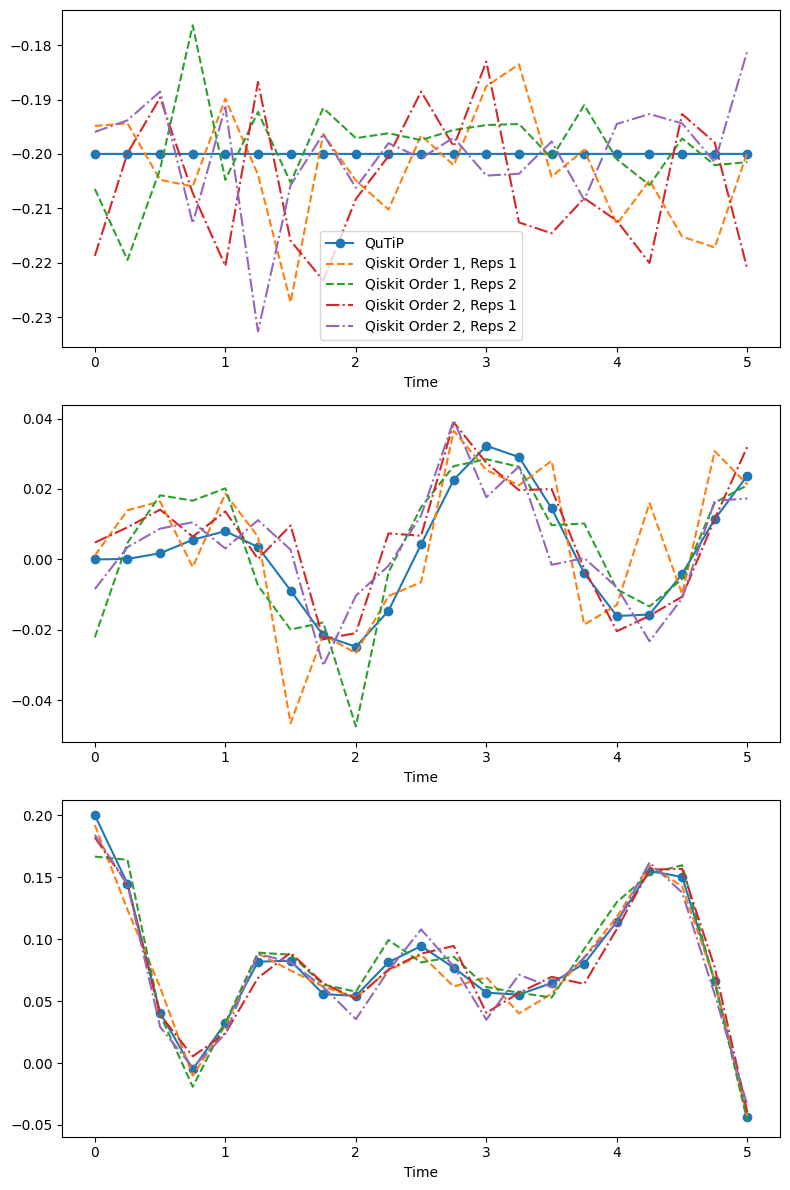

In [ ]:
fig, axes = plt.subplots(len(e_ops_tuples), 1, figsize=(8, 4 * len(e_ops_tuples)))
labels = ["Energy", "Magnetization", "Correlation"]

for (
    ax,
    label,
    (qutip_ev, qiskit_ev_1, qiskit_ev_2),
) in zip(
    axes.flat,
    labels,
    zip(
        qutip_results,
        qiskit_results_1,
        qiskit_results_2,
    ),
):
    ax.plot(times, qutip_ev, label="QuTiP", marker="o")
    ax.plot(times, qiskit_ev_1, label="Qiskit Order 1", linestyle="--")
    ax.plot(times, qiskit_ev_2, label="Qiskit Order 2", linestyle="--")
    ax.set_xlabel("Time")
    if ax == axes.flat[0]:
        ax.legend()

plt.tight_layout()
plt.show()